In [1]:
# Load data
import pandas as pd

data = pd.read_csv("../data/ADS_baselineDataset.csv", index_col=0)

In [2]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y, shuffle=True
)

# Preprocessing

We notice that most issues we observed in the previous sections, are not present in the baseline dataset. As shown below, we found no duplicate rows, missing values or missing labels. However, we will still attempt to remove any outliers, and scale the features thereafter.

Furthermore, this dataset is filled with features with Near-Zero variance. Therefore, we add an additional step to remove all such features.

In [3]:
import sys

sys.path.append("..")
from src.preprocessing import DuplicateRemover

_ = DuplicateRemover().fit_transform(X, y)

Removed 0 duplicate rows


In [4]:
import numpy as np

print(f"There are {np.count_nonzero(np.isnan(X))} missing values.")

There are 0 missing values.


In [5]:
print(f"There are {np.count_nonzero(np.isnan(y))} missing labels.")

There are 0 missing labels.


In [6]:
import sys

sys.path.append("..")
from src.pipeline import PreprocessingPipeline

preprocessing_pipeline = PreprocessingPipeline(
    frequency_threshold=0.9, outlier_threshold=1.25
)

In [7]:
X_train, y_train = preprocessing_pipeline.fit_transform(X_train, y_train)
X_test, y_test = preprocessing_pipeline.transform(X_test, y_test)

Found 587 columns with Near-Zero Variance


We can further notice that there are no features with high cross-correlations, meaning the features can be assumed to not be heavily related.

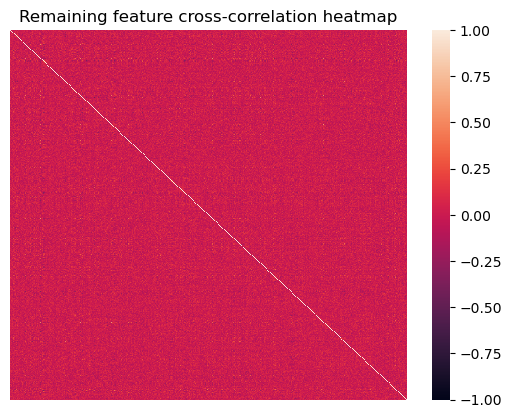

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(pd.DataFrame(X_train).corr(), vmax=1, vmin=-1)
plt.title("Remaining feature cross-correlation heatmap")
plt.axis("off")
plt.show()

In [9]:
corr_matrix = pd.DataFrame(X_train).corr()

In [10]:
print(
    f"Minimum correlation coefficient between features: {corr_matrix[corr_matrix != 1].min().min():.3f}"
)
print(
    f"Maximum correlation coefficient between features: {corr_matrix[corr_matrix != 1].max().max():.3f}"
)

Minimum correlation coefficient between features: -0.420
Maximum correlation coefficient between features: 0.566


We further explore dimensionality reduction, so we can interpret the task better. From the plot below, we observe that separation should be reasonably possible, even in a 2-dimensional space.

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)

X_pca = pca.fit_transform(X_train)

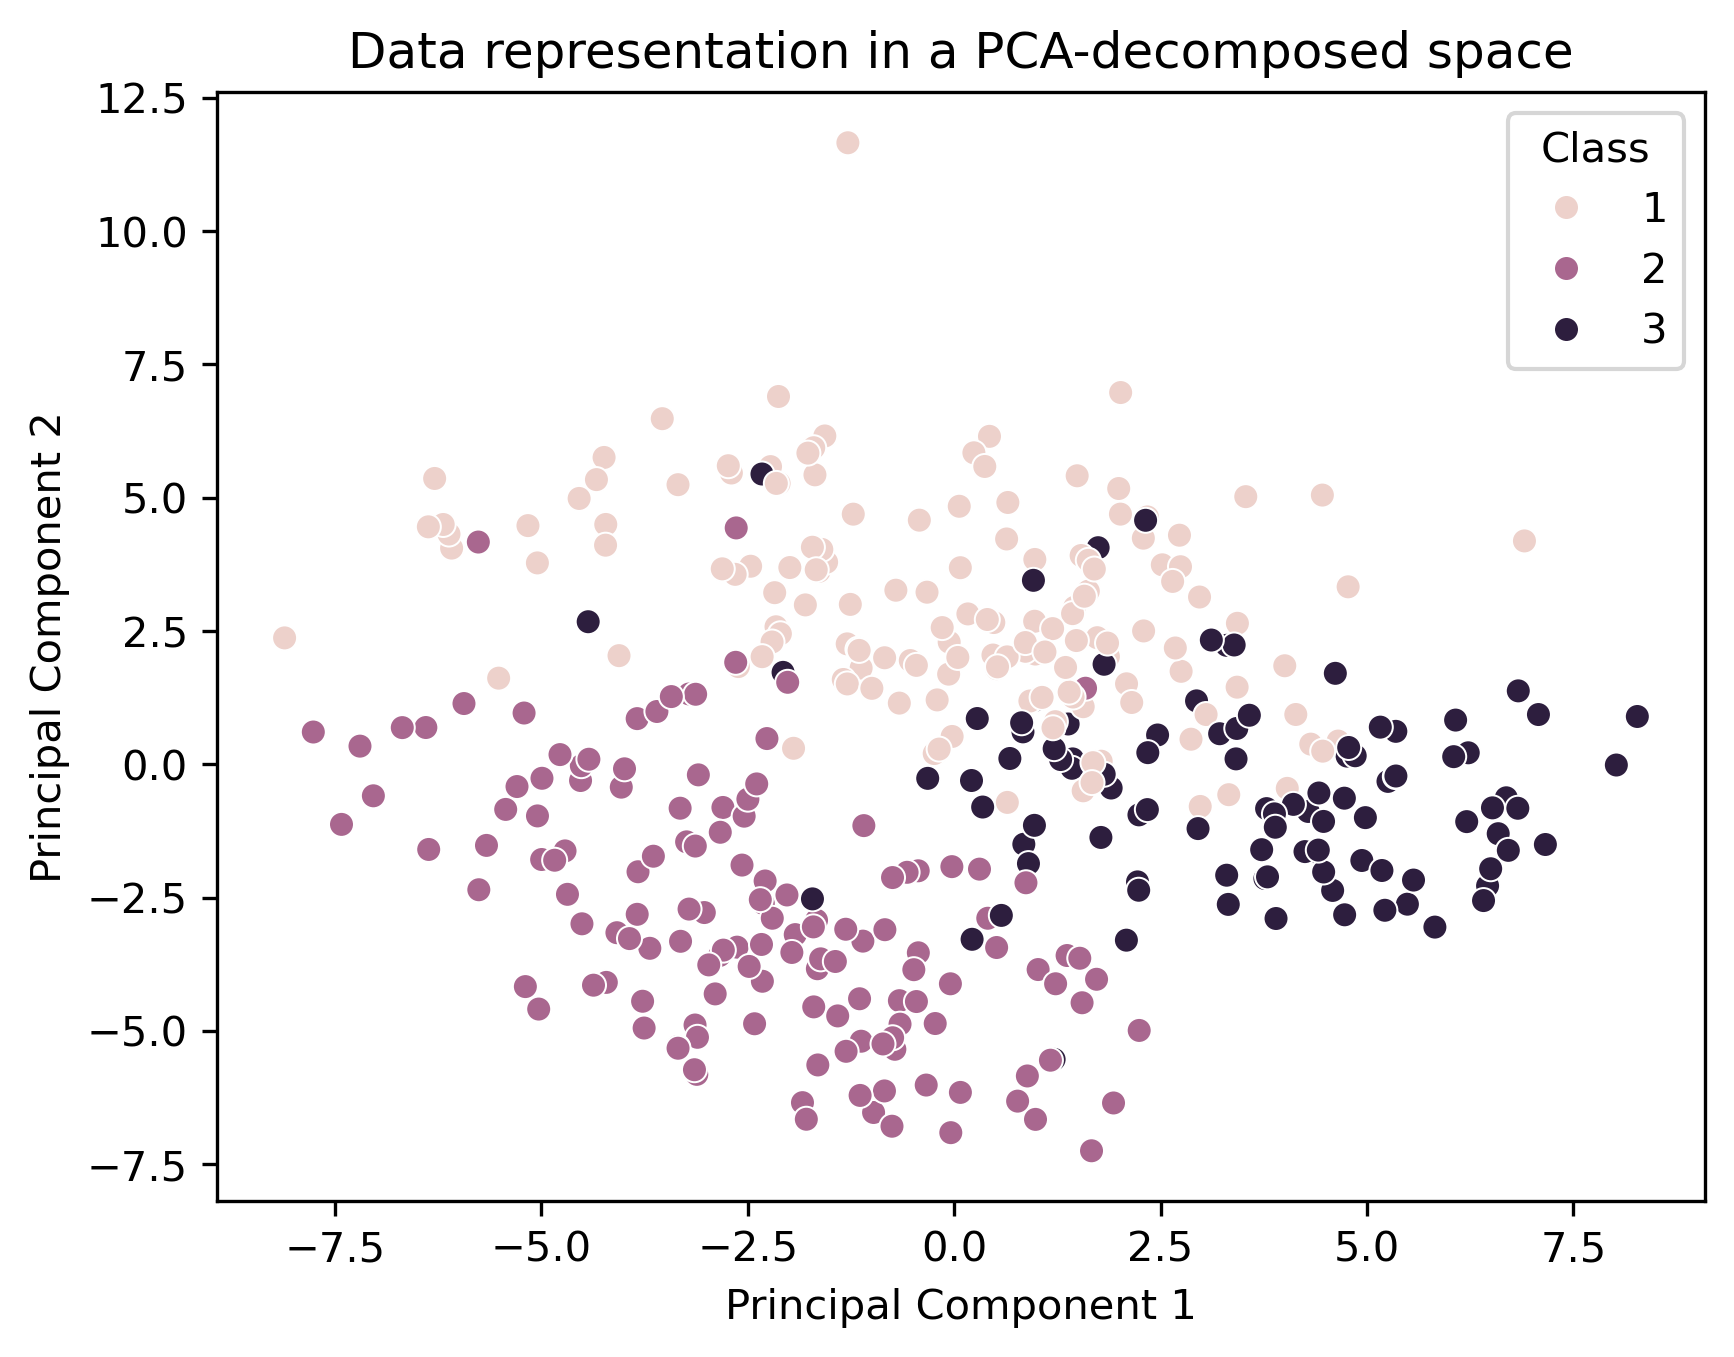

In [12]:
import matplotlib.pyplot as plt

plt.figure(dpi=300)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.title("Data representation in a PCA-decomposed space")
plt.show()

We repeat the same experiment using a different decomposition method (SVD), which shows no major differences.

In [13]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)

X_svd = svd.fit_transform(X_train)

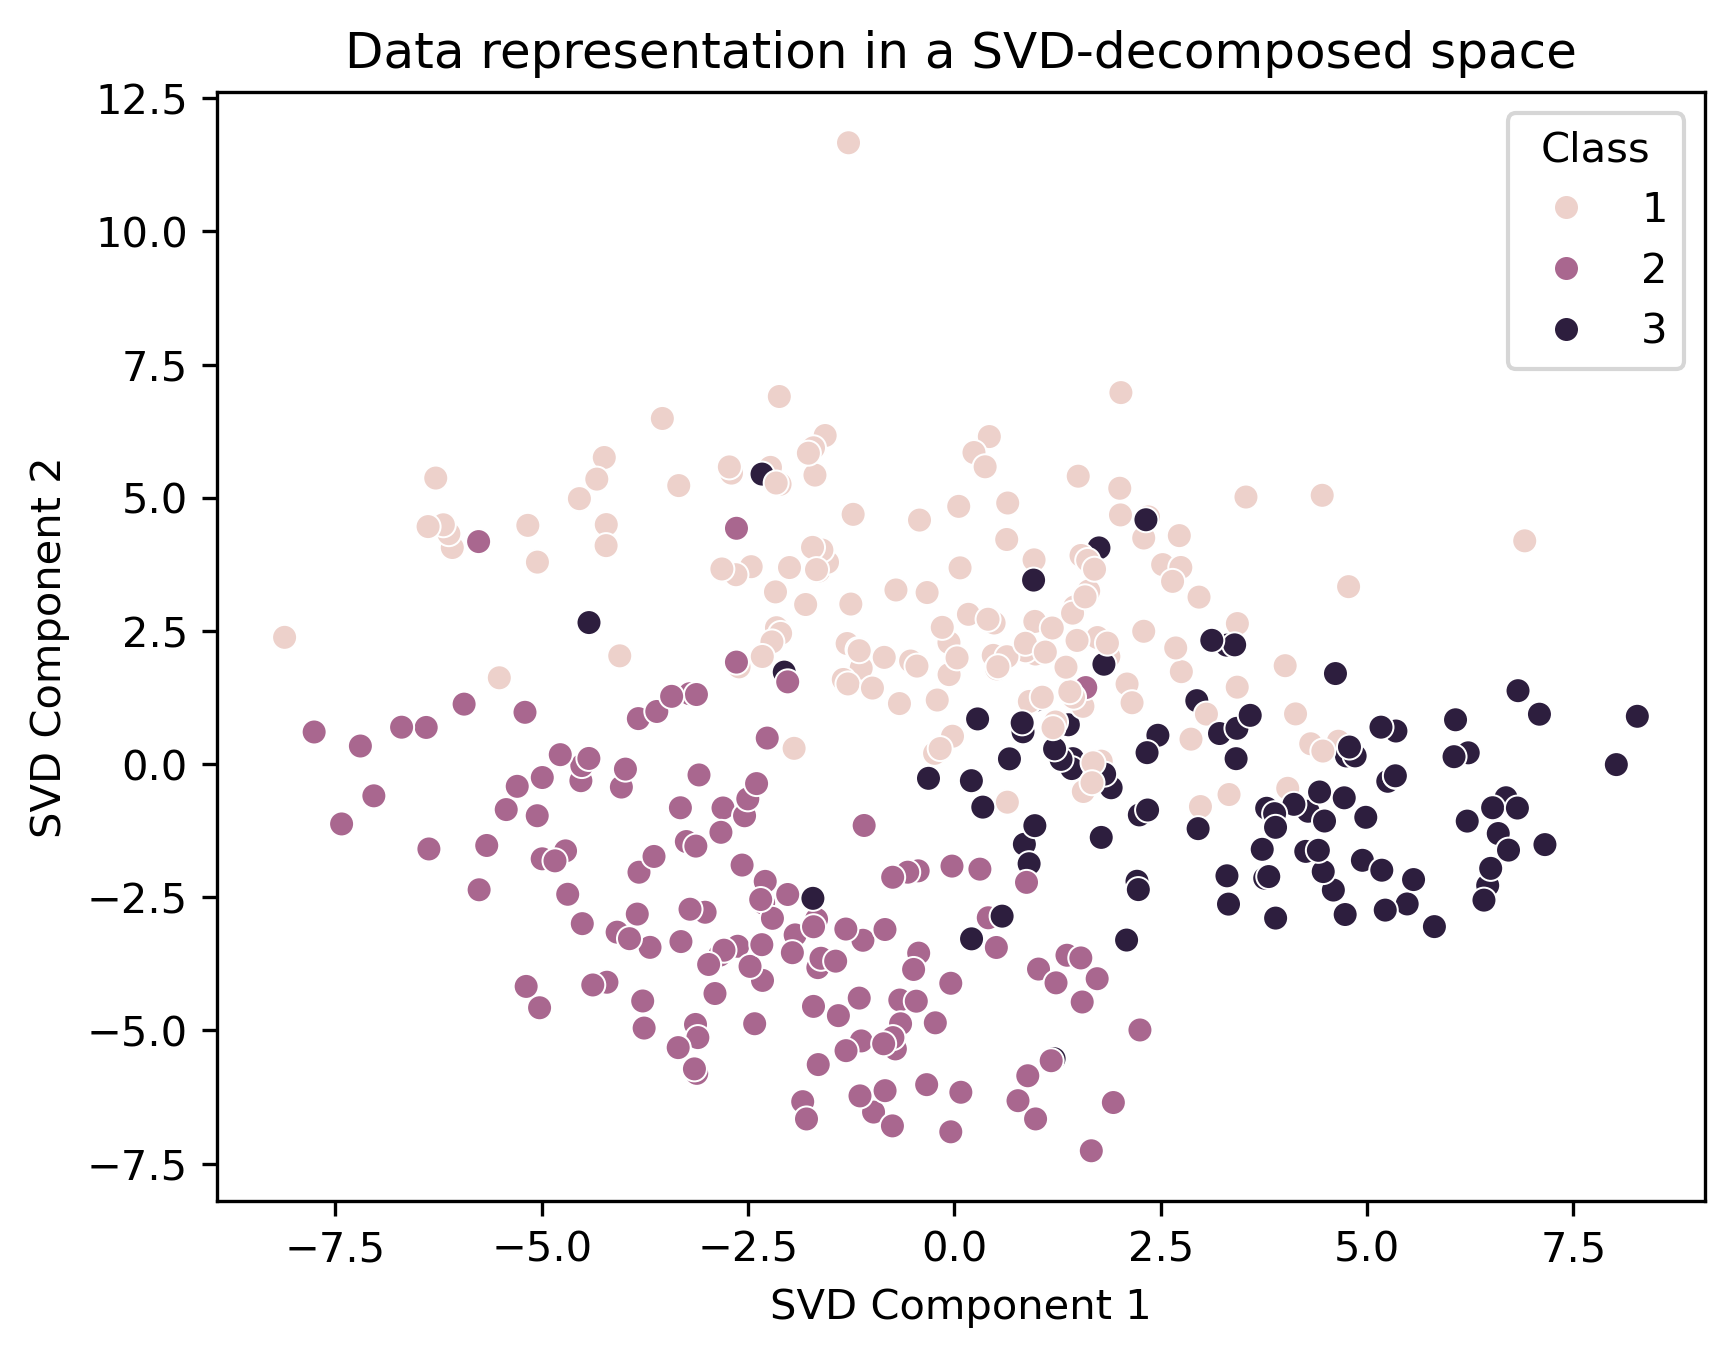

In [14]:
import matplotlib.pyplot as plt

plt.figure(dpi=300)
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=y_train)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(title="Class")
plt.title("Data representation in a SVD-decomposed space")
plt.show()

# Random Forest

## Default classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

classifier_default = RandomForestClassifier(random_state=42, oob_score=True)
classifier_default.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [16]:
print(f"Train accuracy: {classifier_default.score(X_train, y_train)*100:.1f}%")
print(f"Test accuracy: {classifier_default.score(X_test, y_test)*100:.1f}%")
print(f"Out of bag samples score: {classifier_default.oob_score_*100:.1f}%")

Train accuracy: 100.0%
Test accuracy: 94.0%
Out of bag samples score: 90.1%


<Figure size 1920x1440 with 0 Axes>

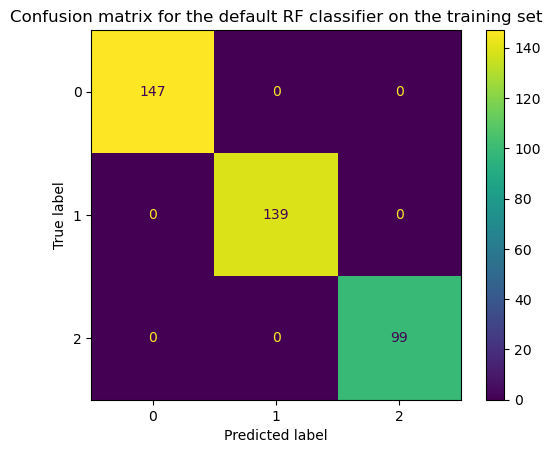

In [17]:
sys.path.append("..")
from src.evaluation import confusion_matrix_plot

confusion_matrix_plot(classifier_default, X_train, y_train)
plt.title("Confusion matrix for the default RF classifier on the training set")
plt.show()

<Figure size 1920x1440 with 0 Axes>

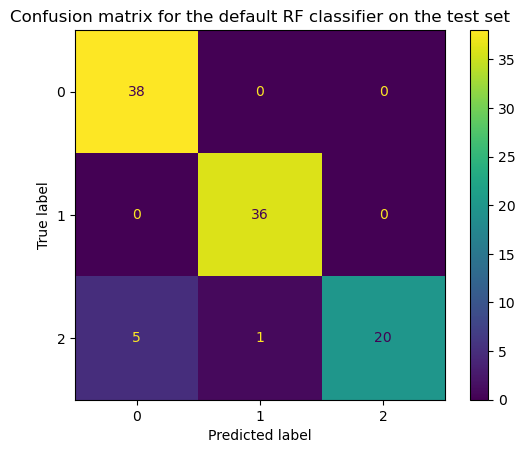

In [18]:
confusion_matrix_plot(classifier_default, X_test, y_test)
plt.title("Confusion matrix for the default RF classifier on the test set")
plt.show()

## Optimizing using OOB score

In [19]:
n_trees_options = range(10, 300, 10)
scores = []
test_scores = []
best_score = 0
best_n_trees = 10
for n_trees in n_trees_options:
    classifier = RandomForestClassifier(
        random_state=42, oob_score=True, n_estimators=n_trees
    )
    classifier.fit(X_train, y_train)
    # Calculate train OOB score
    score = classifier.oob_score_
    scores.append(score)
    test_scores.append(classifier.score(X_test, y_test))
    # Select best score
    if score > best_score:
        best_score = score
        best_n_trees = n_trees

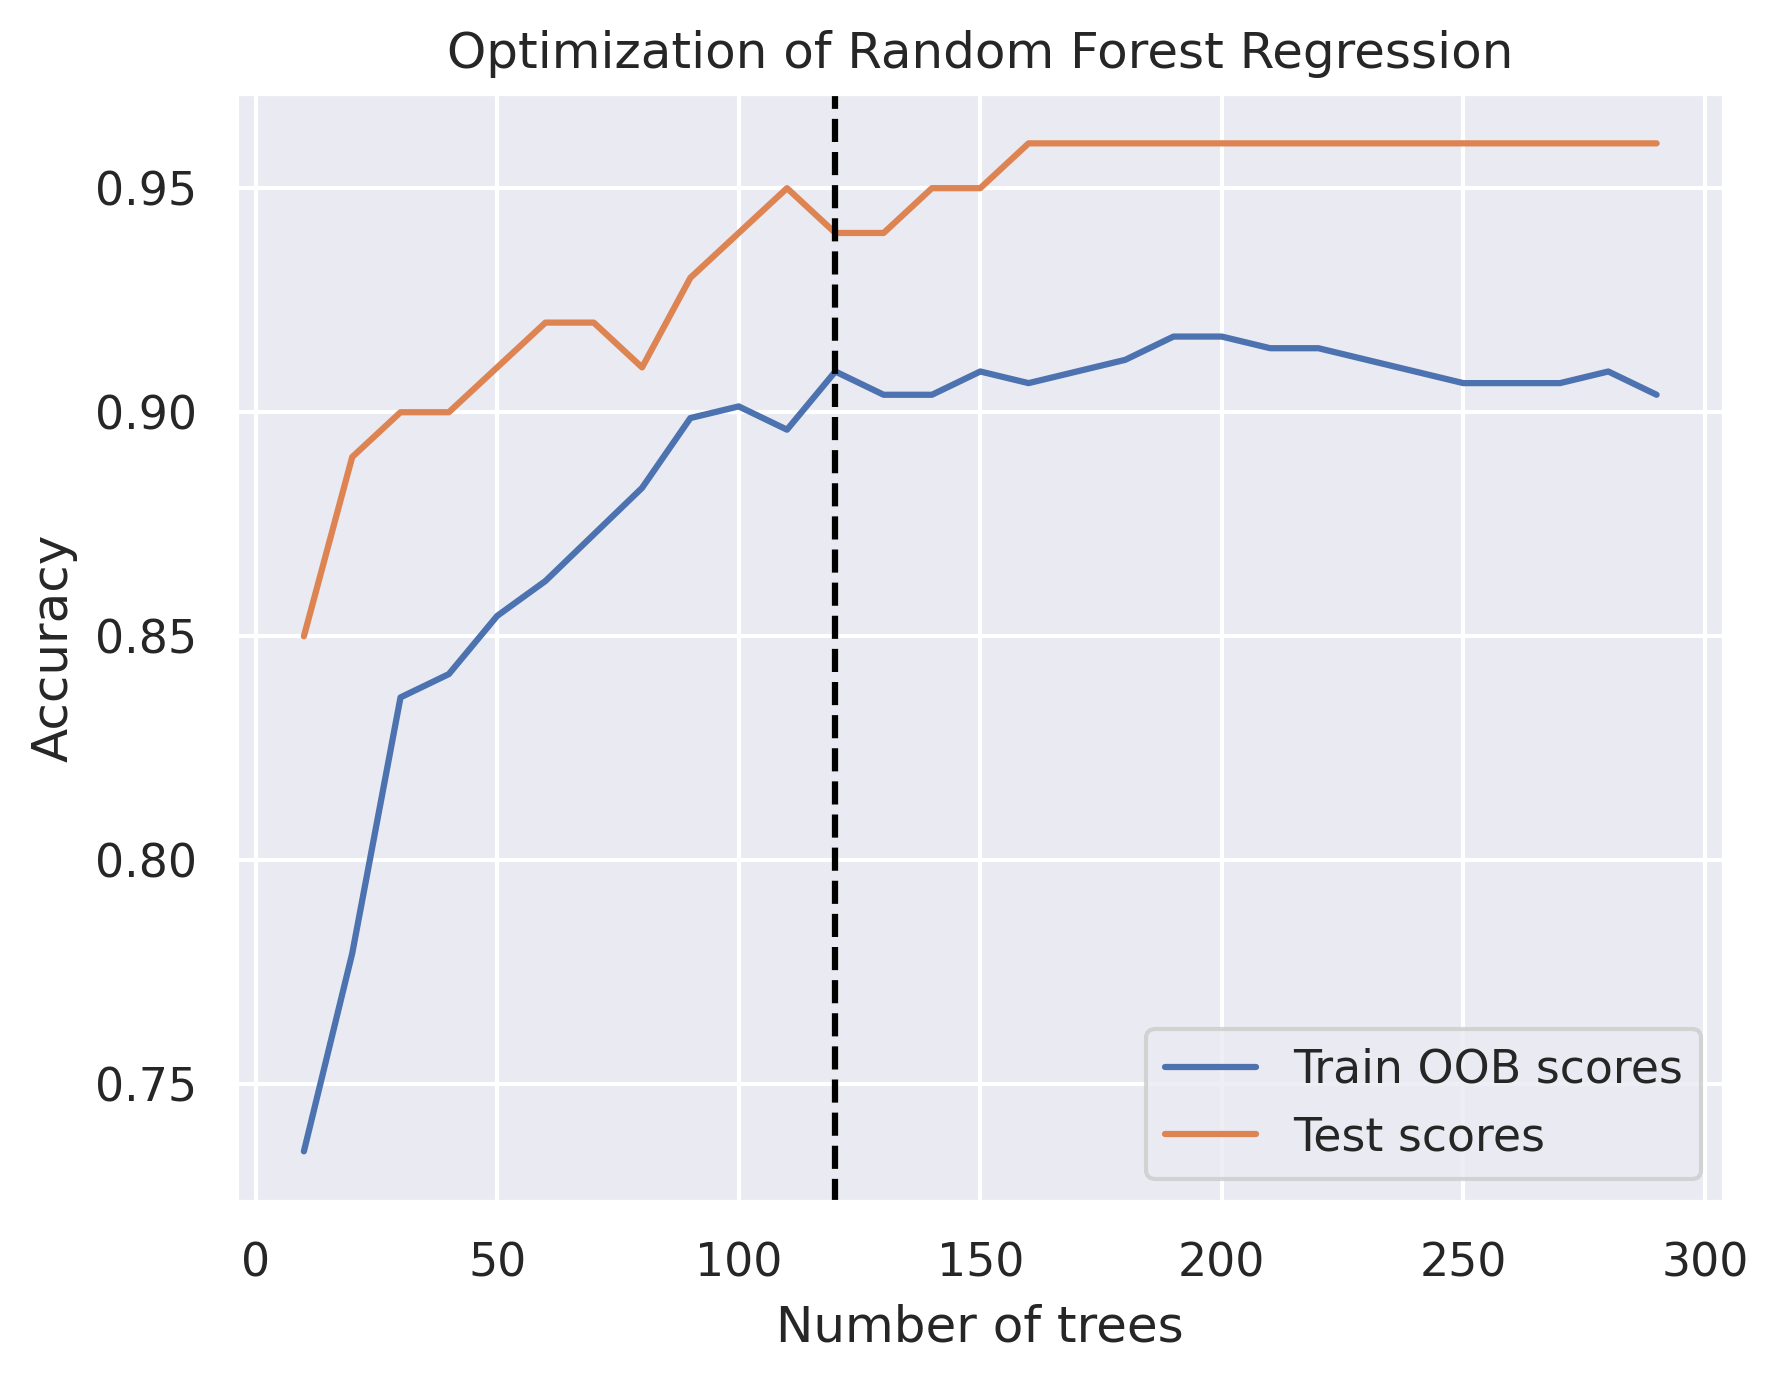

In [20]:
sns.set()
plt.figure(dpi=300)
plt.plot(n_trees_options, scores, label="Train OOB scores")
plt.plot(n_trees_options, test_scores, label="Test scores")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.axvline(120, linestyle="--", color="black")
plt.legend()
plt.title("Optimization of Random Forest Regression")
plt.show()
sns.reset_orig()

In [21]:
optimized_model = classifier = RandomForestClassifier(
    random_state=42, oob_score=True, n_estimators=120
)
optimized_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120, oob_score=True, random_state=42)

<Figure size 1920x1440 with 0 Axes>

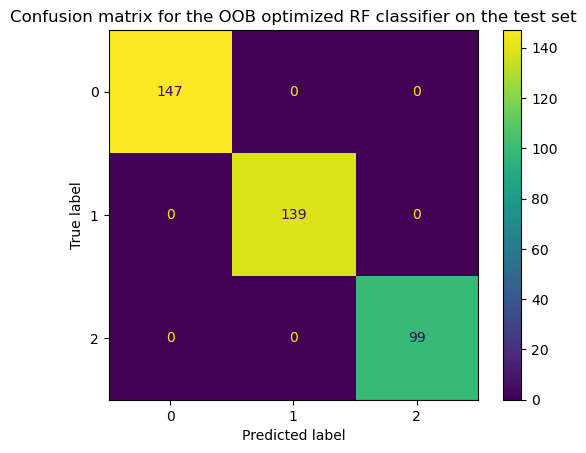

In [22]:
confusion_matrix_plot(optimized_model, X_train, y_train)
plt.title("Confusion matrix for the OOB optimized RF classifier on the test set")
plt.show()

<Figure size 1920x1440 with 0 Axes>

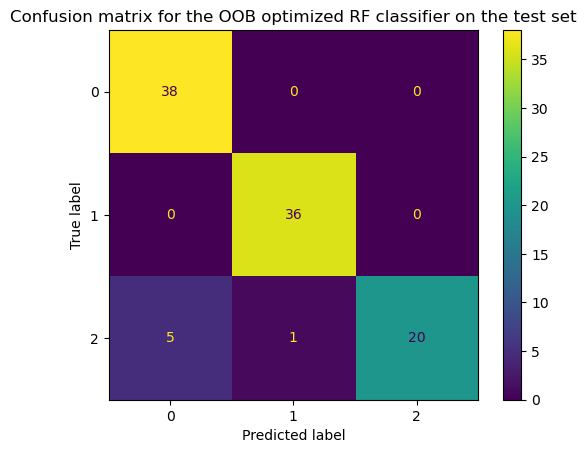

In [23]:
confusion_matrix_plot(optimized_model, X_test, y_test)
plt.title("Confusion matrix for the OOB optimized RF classifier on the test set")
plt.show()

## Feature Importance

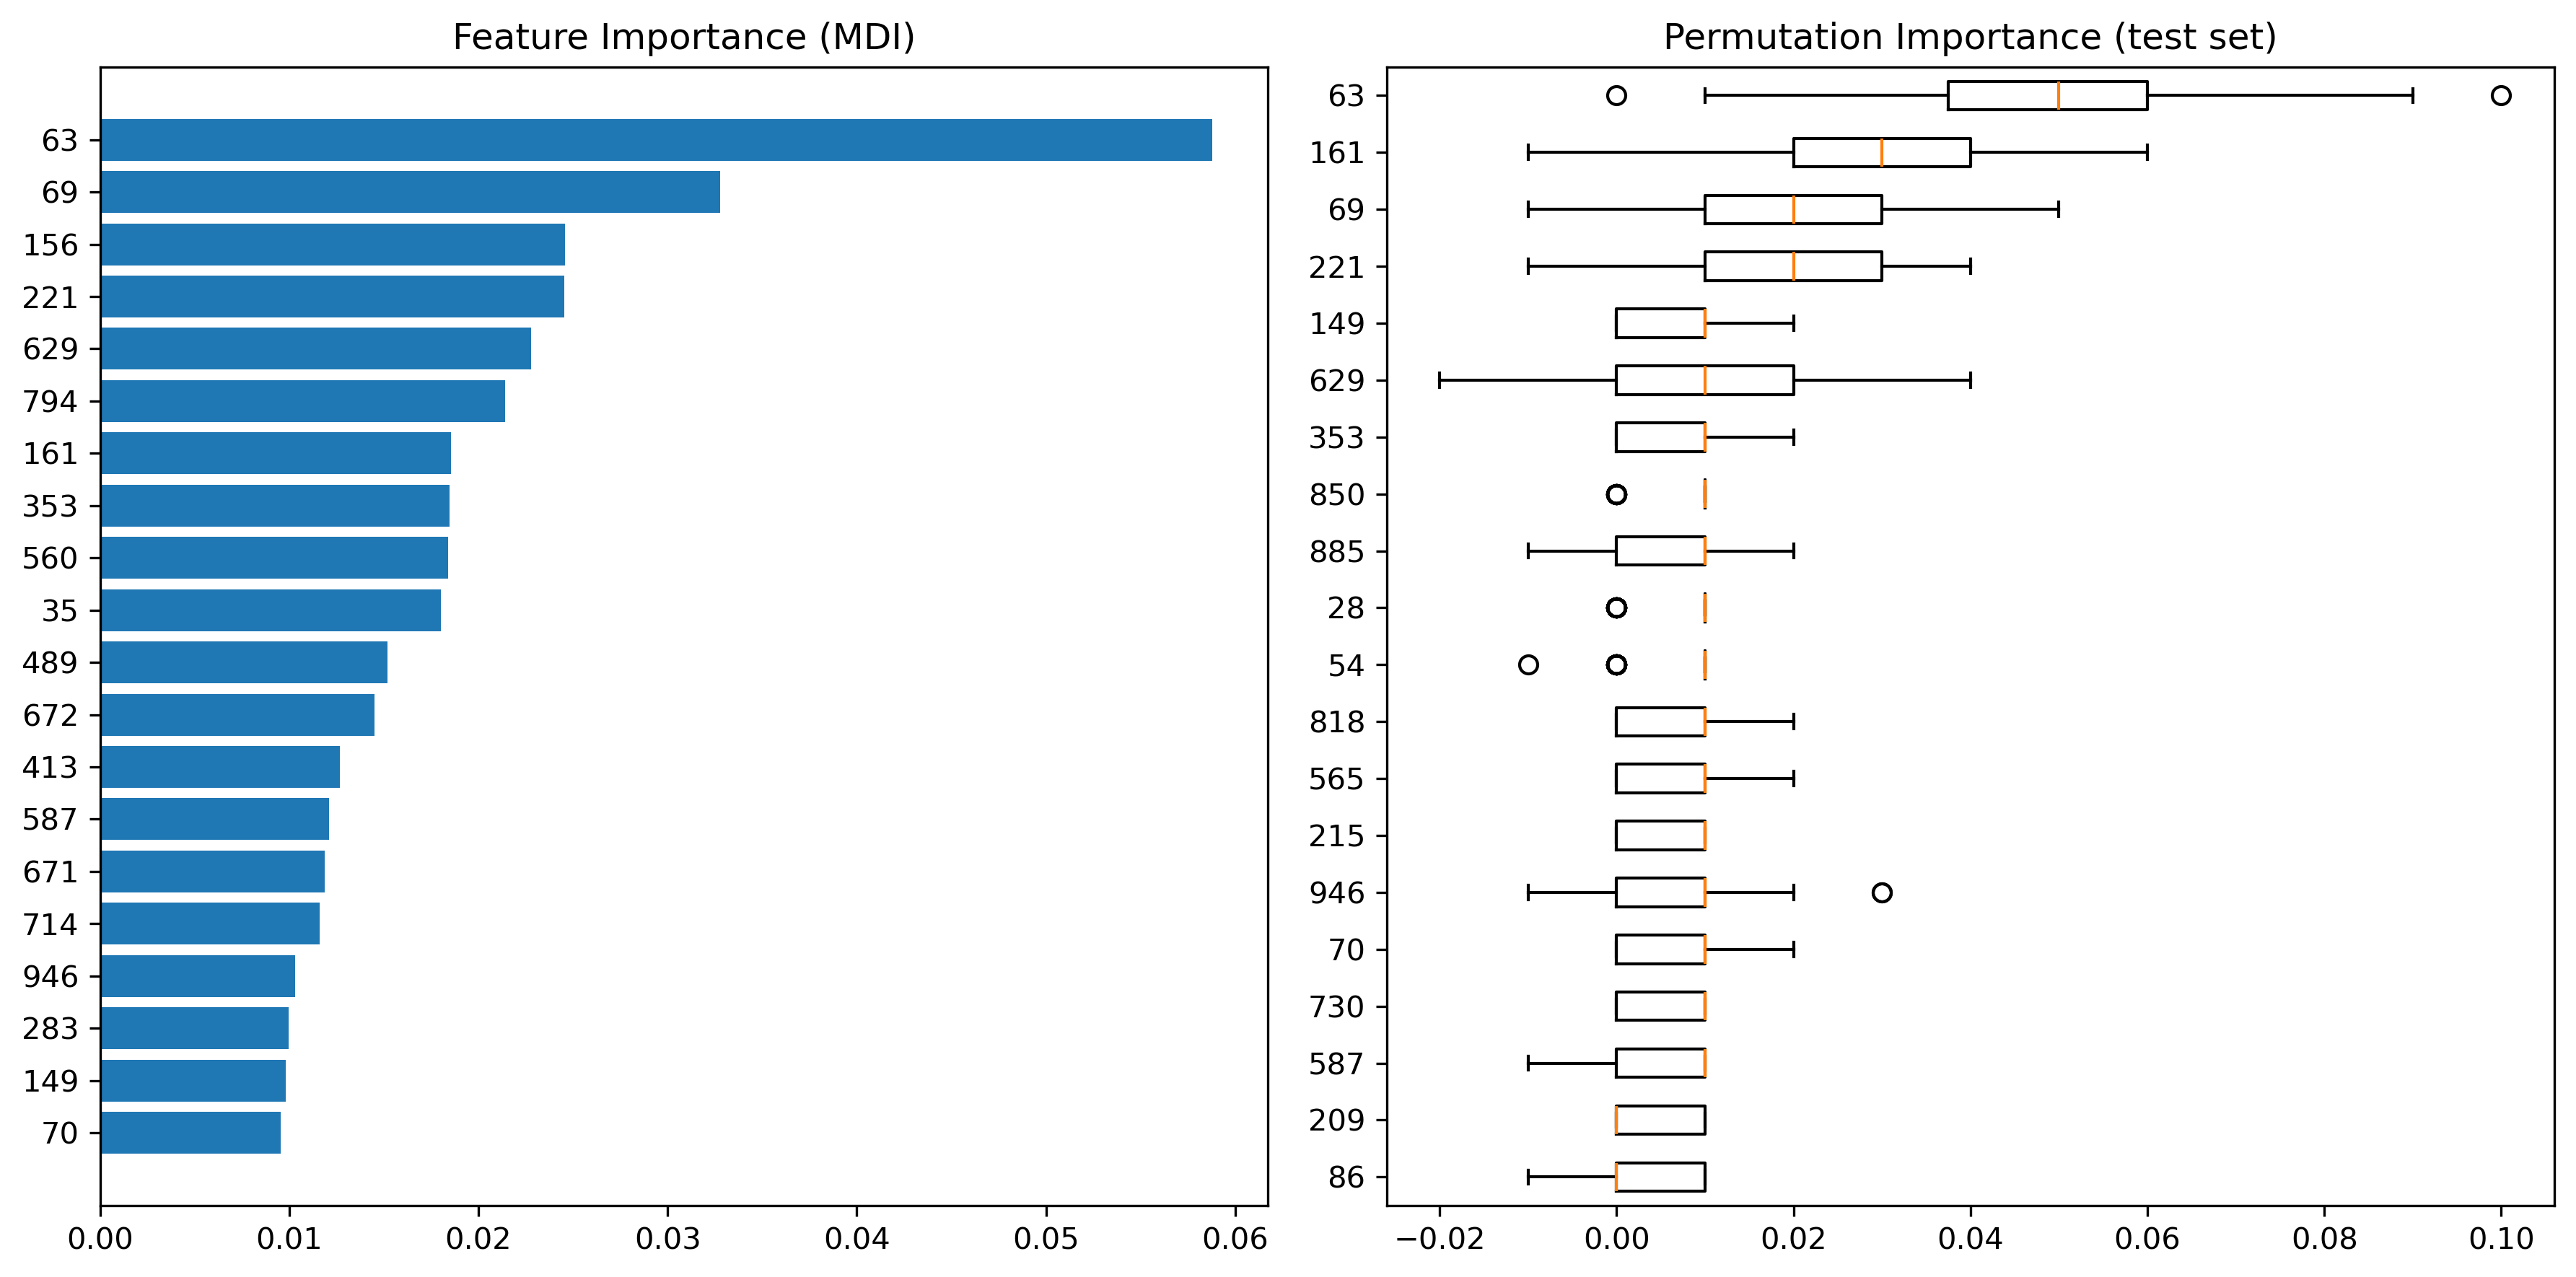

In [24]:
from sklearn.inspection import permutation_importance

# Training feature importance
feature_importance = optimized_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, preprocessing_pipeline.nzremover.column_mask.nonzero()[0][sorted_idx])
plt.title("Feature Importance (MDI)")

# Test feature importance using permutation

result = permutation_importance(
    optimized_model, X_test, y_test, n_repeats=100, random_state=42, n_jobs=2
)
sorted_idx_perm = result.importances_mean.argsort()[-20:]

plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx_perm].T,
    vert=False,
    labels=preprocessing_pipeline.nzremover.column_mask.nonzero()[0][sorted_idx_perm],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [25]:
best_features = sorted_idx_perm[-7:]
X_train_cut = X_train[:, best_features]
X_test_cut = X_test[:, best_features]

n_trees_options = range(10, 300, 10)
scores = []
test_scores = []
best_score = 0
best_n_trees = 10
# Reoptimize for less features
for n_trees in n_trees_options:
    classifier = RandomForestClassifier(
        random_state=42, oob_score=True, n_estimators=n_trees
    )
    classifier.fit(X_train_cut, y_train)
    # Calculate training OOB score
    score = classifier.oob_score_
    scores.append(score)
    test_scores.append(classifier.score(X_test_cut, y_test))
    # Select best model
    if score > best_score:
        best_score = score
        best_n_trees = n_trees

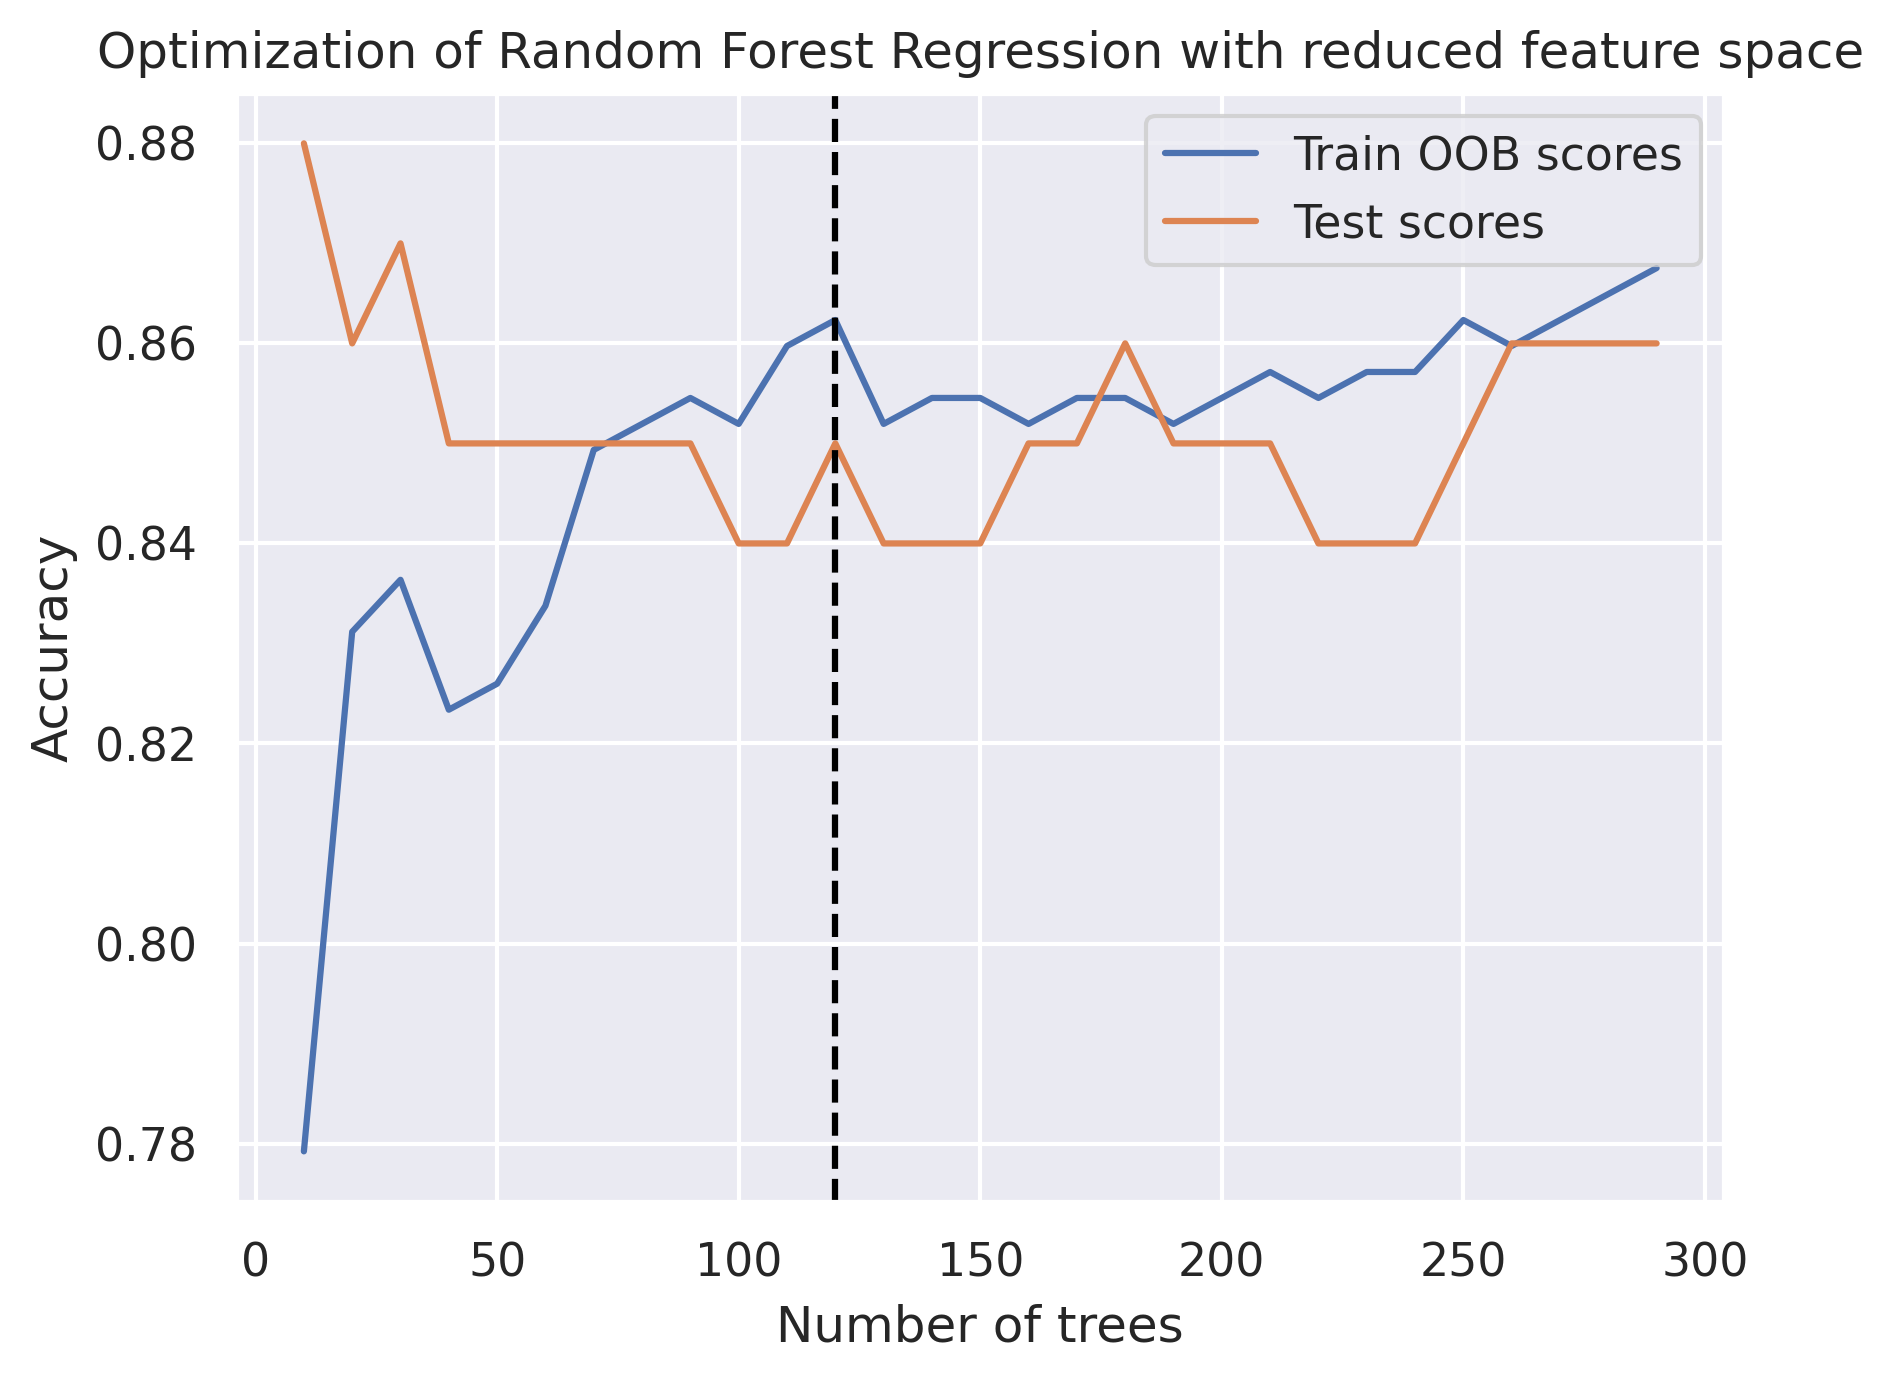

In [26]:
sns.set()
plt.figure(dpi=300)
plt.plot(n_trees_options, scores, label="Train OOB scores")
plt.plot(n_trees_options, test_scores, label="Test scores")
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")
plt.axvline(120, linestyle="--", color="black")
plt.legend()
plt.title("Optimization of Random Forest Regression with reduced feature space")
plt.show()
sns.reset_orig()

In [27]:
# Refit optimized model
optimized_model = RandomForestClassifier(
    random_state=42, oob_score=True, n_estimators=120
)
optimized_model.fit(X_train_cut, y_train)

RandomForestClassifier(n_estimators=120, oob_score=True, random_state=42)

In [28]:
print(f"Train accuracy: {optimized_model.score(X_train_cut, y_train)*100:.1f}%")
print(f"Test accuracy: {optimized_model.score(X_test_cut, y_test)*100:.1f}%")
print(f"Out of bag samples score: {optimized_model.oob_score_*100:.1f}%")

Train accuracy: 100.0%
Test accuracy: 85.0%
Out of bag samples score: 86.2%


<Figure size 1920x1440 with 0 Axes>

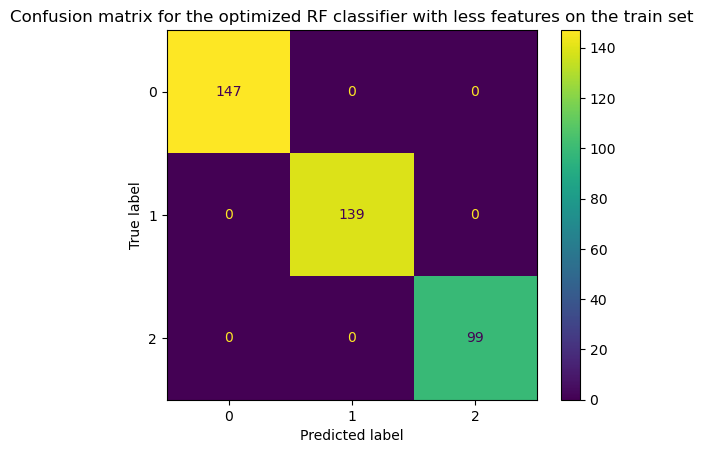

In [29]:
confusion_matrix_plot(optimized_model, X_train_cut, y_train)
plt.title(
    "Confusion matrix for the optimized RF classifier with less features on the train set"
)
plt.show()

<Figure size 1920x1440 with 0 Axes>

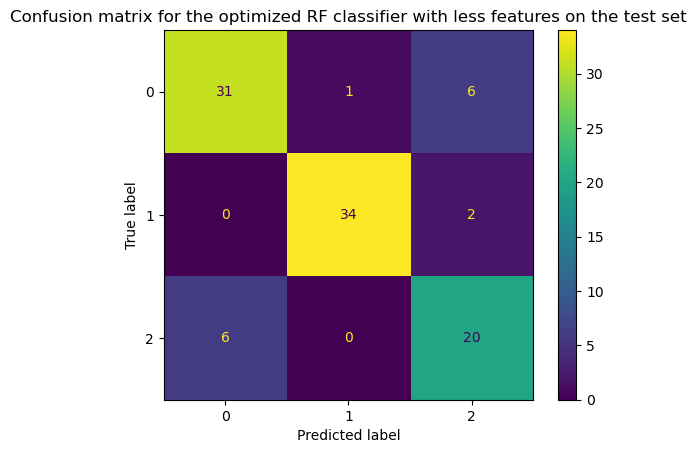

In [30]:
confusion_matrix_plot(optimized_model, X_test_cut, y_test)
plt.title(
    "Confusion matrix for the optimized RF classifier with less features on the test set"
)
plt.show()

## Further Cross-validation

We try to improve the model further using rigorous cross-validation.

In [31]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from src.pipeline import RFPipeline

relevant_columns = preprocessing_pipeline.nzremover.column_mask.nonzero()[0][
    best_features
]
X_train, X_test, y_train, y_test = train_test_split(
    X[:, relevant_columns], y, train_size=0.8, random_state=42, stratify=y, shuffle=True
)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid = {
    "frequency_threshold": [0.9],
    "outlier_threshold": [1.25],
    "n_estimators": [10, 30, 50, 100, 120, 130, 150, 180],
    "max_depth": [2, 3, 4, 5, 6],
    "max_features": [2, 3, 4],
    "random_state": [42],
}
grid_search = GridSearchCV(RFPipeline(0.8, 1.25), grid, scoring="accuracy", cv=cv)

In [32]:
%%capture
# Disable printing
grid_search.fit(X_train, y_train)

In [33]:
print(f"Train accuracy: {grid_search.best_estimator_.score(X_train, y_train)*100:.1f}%")
print(f"Test accuracy: {grid_search.best_estimator_.score(X_test, y_test)*100:.1f}%")

Train accuracy: 94.0%
Test accuracy: 85.0%


# Support Vector Machine

## Default Classifier

In [34]:
from sklearn.svm import SVC

svm_default = SVC(random_state=42)
svm_default.fit(X_train, y_train)

SVC(random_state=42)

We notice that the default performance from the SVC is much worse than the one for the RFC

In [35]:
print(f"Train accuracy: {svm_default.score(X_train, y_train)*100:.1f}%")
print(f"Test accuracy: {svm_default.score(X_test, y_test)*100:.1f}%")

Train accuracy: 89.0%
Test accuracy: 82.0%


<Figure size 1920x1440 with 0 Axes>

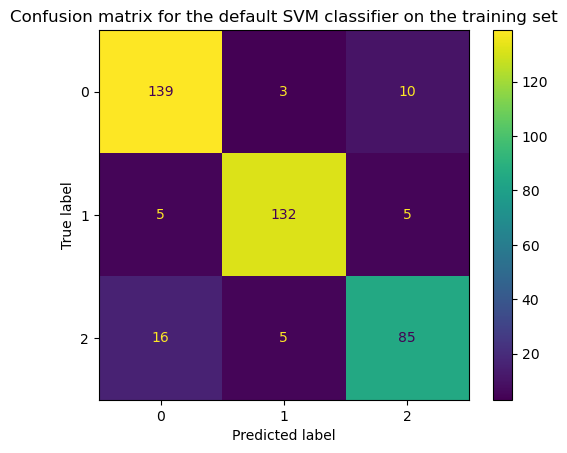

In [36]:
sns.reset_orig()
confusion_matrix_plot(svm_default, X_train, y_train)
plt.title("Confusion matrix for the default SVM classifier on the training set")
plt.show()

<Figure size 1920x1440 with 0 Axes>

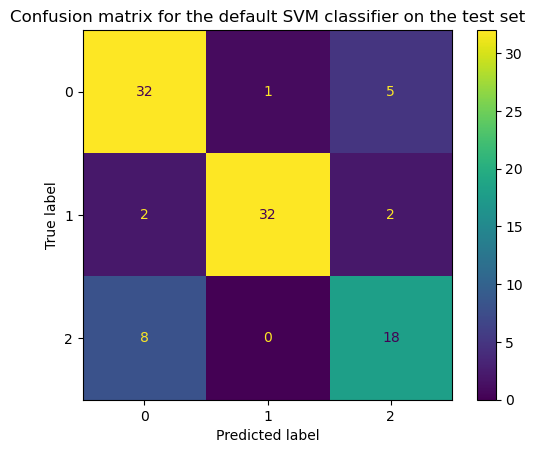

In [37]:
confusion_matrix_plot(svm_default, X_test, y_test)
plt.title("Confusion matrix for the default SVM classifier on the test set")
plt.show()

## Optimization

We optimize the SVM using rigorous Grid Search, including the preprocessing pipeline. We do not include the outlier threshold, as the search is biased towards higher generalization, i.e. removing more data points.

In [38]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from src.pipeline import SVCPipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y, shuffle=True
)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
grid = {
    "frequency_threshold": [0.8, 0.85, 0.9, 0.95],
    "outlier_threshold": [1.25],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
    "probability": [True],
}
grid_search = GridSearchCV(
    SVCPipeline(0.8, 1.25, probability=True), grid, scoring="accuracy", cv=cv
)

In [39]:
%%capture
# Disable printing
grid_search.fit(X_train, y_train)

In [40]:
print(f"Train accuracy: {grid_search.best_estimator_.score(X_train, y_train)*100:.1f}%")
print(f"Test accuracy: {grid_search.best_estimator_.score(X_test, y_test)*100:.1f}%")

Train accuracy: 96.0%
Test accuracy: 96.0%


<Figure size 1920x1440 with 0 Axes>

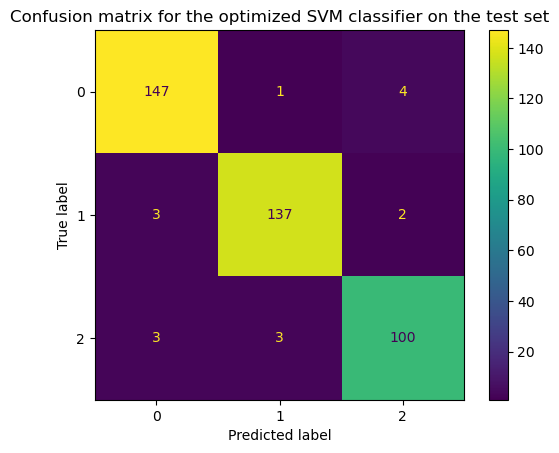

In [41]:
confusion_matrix_plot(grid_search.best_estimator_, X_train, y_train)
plt.title("Confusion matrix for the optimized SVM classifier on the test set")
plt.show()

<Figure size 1920x1440 with 0 Axes>

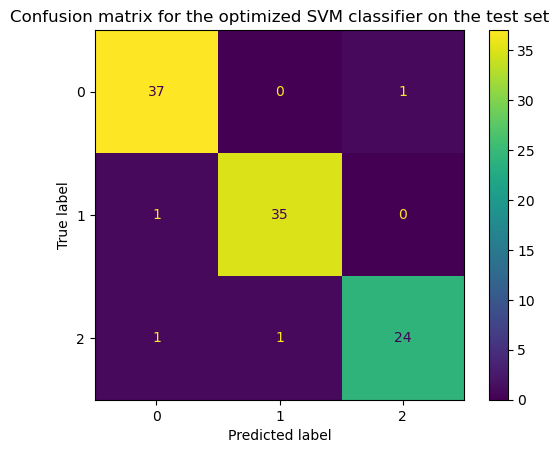

In [42]:
confusion_matrix_plot(grid_search.best_estimator_, X_test, y_test)
plt.title("Confusion matrix for the optimized SVM classifier on the test set")
plt.show()

In [43]:
best_model = grid_search.best_estimator_

## Feature Importance

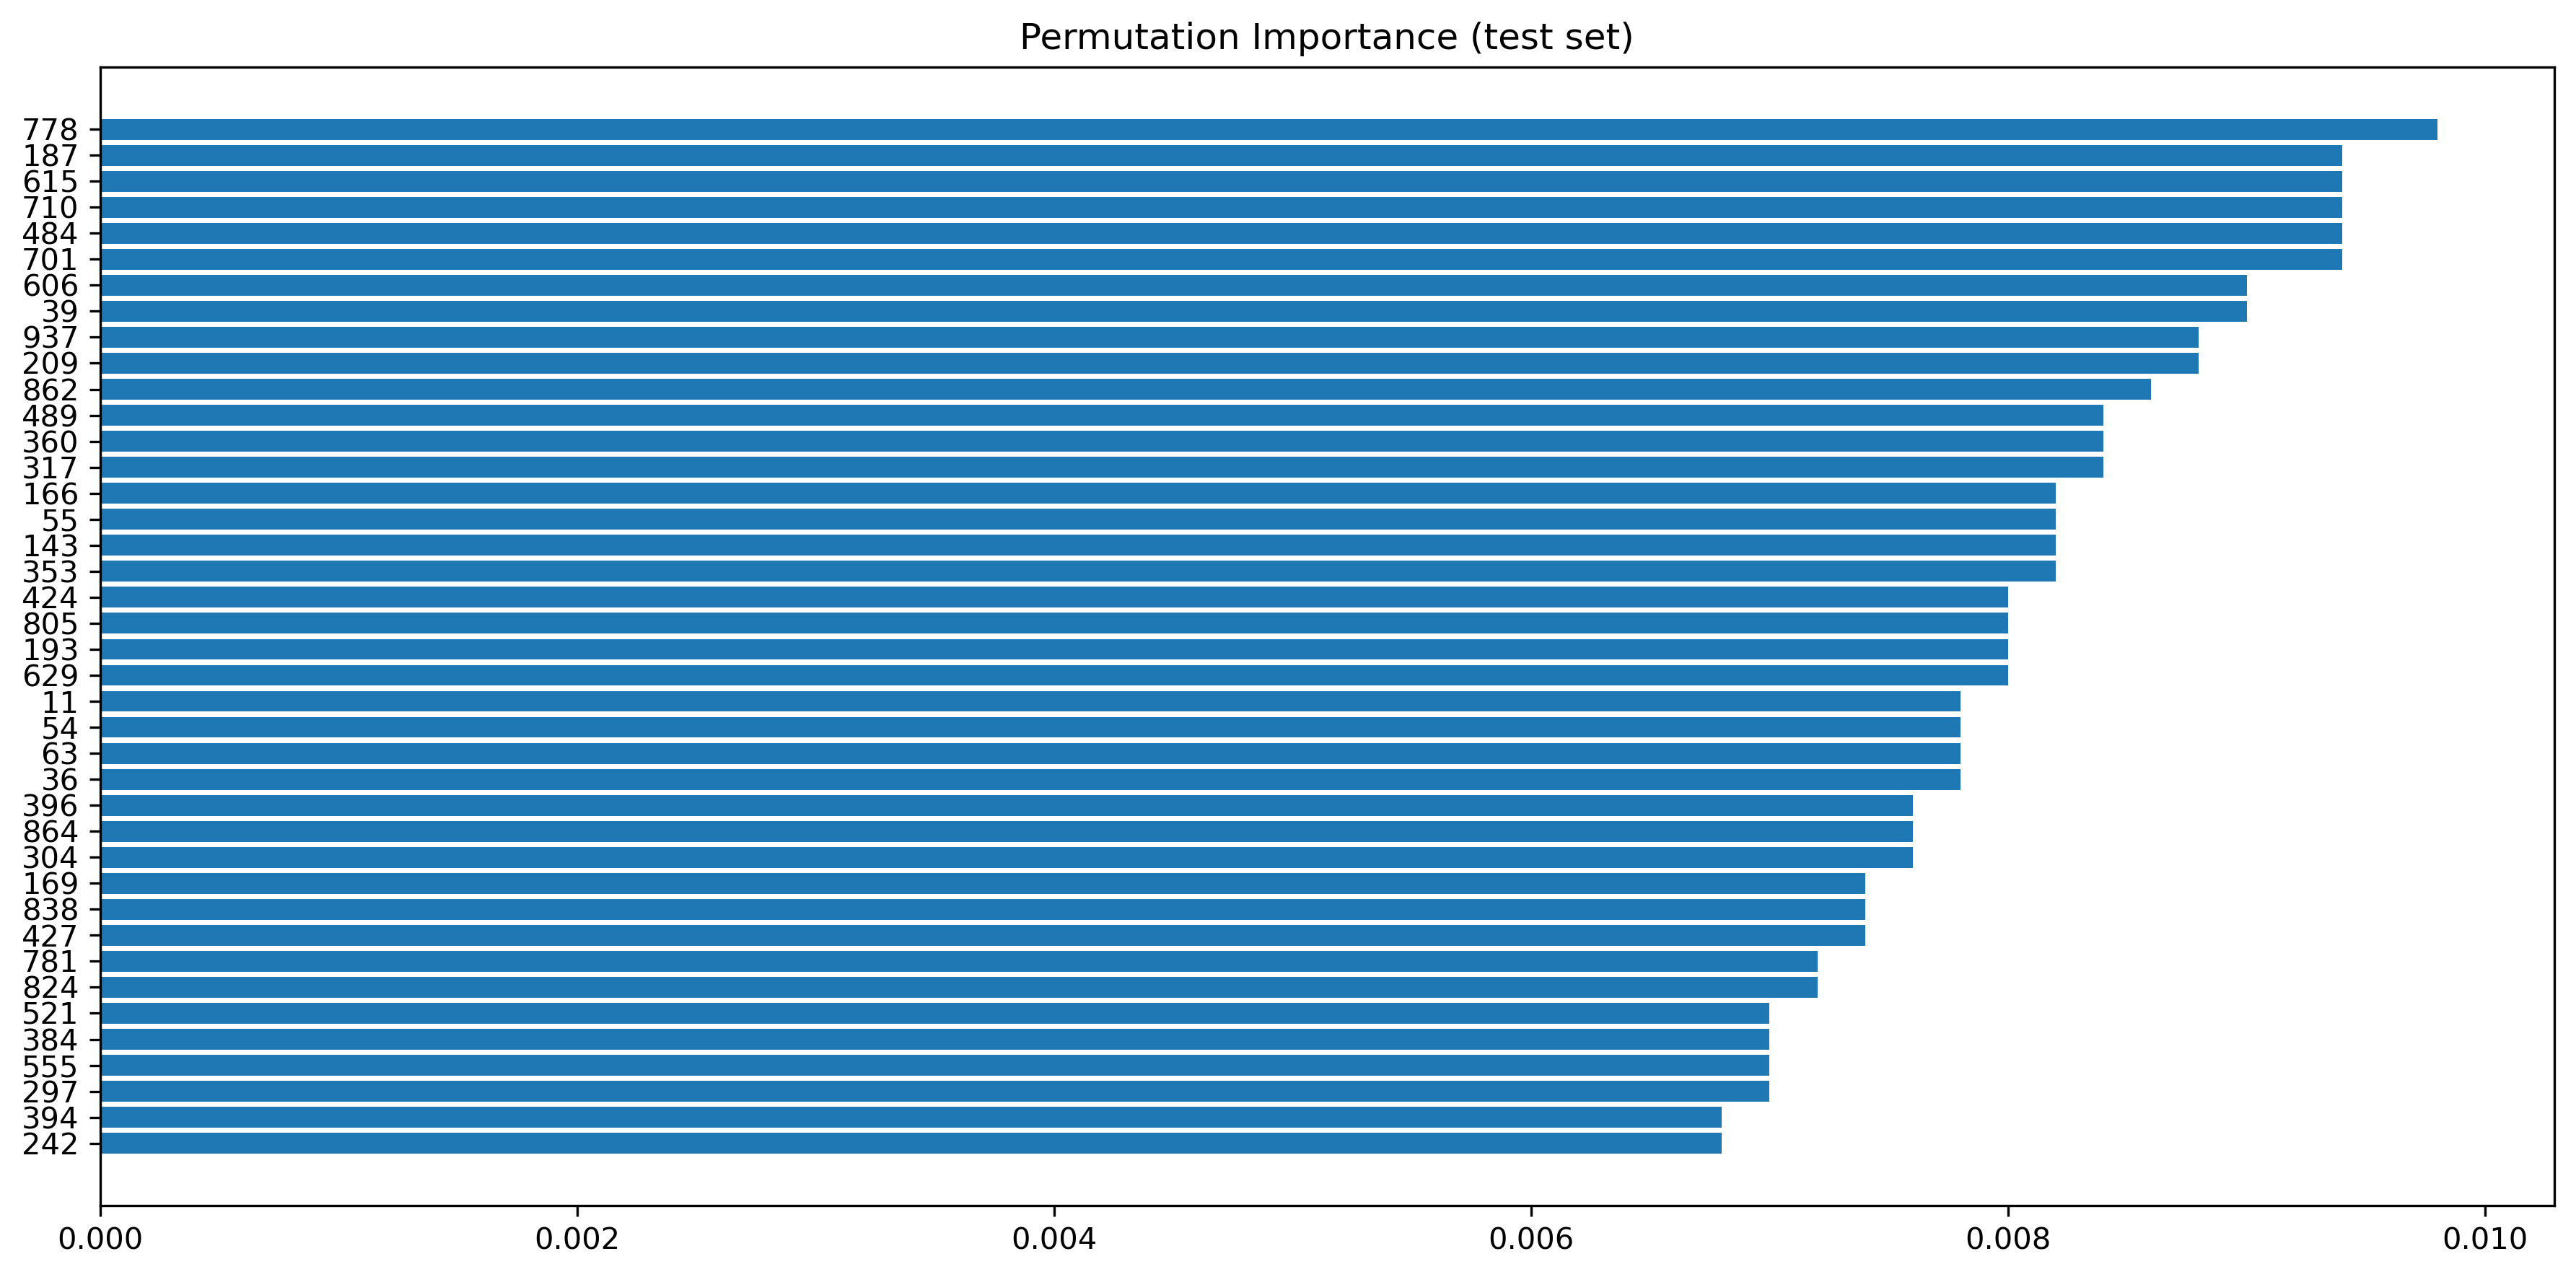

In [44]:
from sklearn.inspection import permutation_importance

fig = plt.figure(figsize=(12, 6), dpi=300)

# We can only measure permutation importance on the test set,
# as the SVC class does not measure them explicitly
result = permutation_importance(
    best_model, X_test, y_test, n_repeats=50, random_state=42, n_jobs=1
)

# Sort the indeces
sorted_idx_perm = result.importances_mean.argsort()

pos = np.arange(sorted_idx_perm[-40:].shape[0]) + 0.5
plt.barh(pos, result.importances_mean[sorted_idx_perm[-40:]], align="center")
plt.yticks(pos, np.arange(X_train.shape[1])[sorted_idx_perm[-40:]])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [45]:
%%capture
# Disable printing
best_features = sorted_idx_perm[-20:]
X_train_cut = X_train[:, best_features]
X_test_cut = X_test[:, best_features]
grid_search.fit(X_train_cut, y_train)

In [46]:
best_model = grid_search.best_estimator_

In [47]:
print(f"Train accuracy: {best_model.score(X_train_cut, y_train)*100:.1f}%")
print(f"Test accuracy: {best_model.score(X_test_cut, y_test)*100:.1f}%")

Train accuracy: 61.3%
Test accuracy: 80.0%


<Figure size 1920x1440 with 0 Axes>

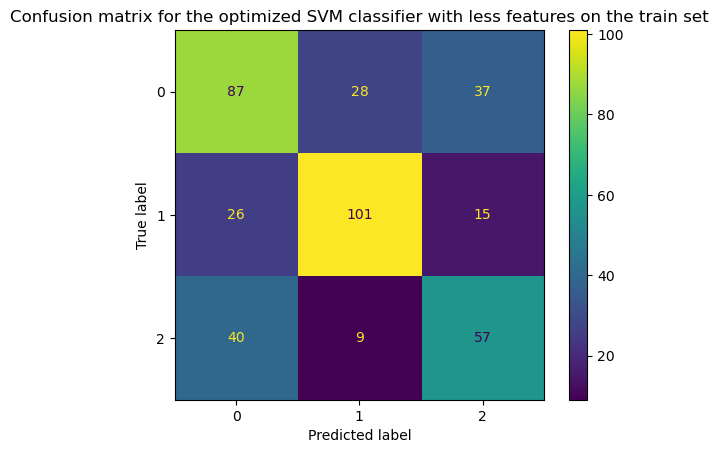

In [48]:
confusion_matrix_plot(best_model, X_train_cut, y_train)
plt.title(
    "Confusion matrix for the optimized SVM classifier with less features on the train set"
)
plt.show()

<Figure size 1920x1440 with 0 Axes>

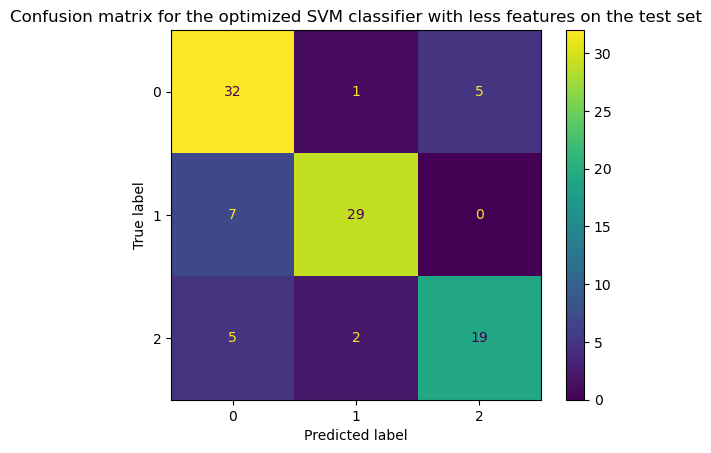

In [49]:
confusion_matrix_plot(best_model, X_test_cut, y_test)
plt.title(
    "Confusion matrix for the optimized SVM classifier with less features on the test set"
)
plt.show()

In [50]:
best_model

SVCPipeline(C=3.0, break_ties=False, cache_size=200, class_weight=None,
            coef0=0.0, decision_function_shape='ovr', degree=3,
            frequency_threshold=0.85, gamma='scale', kernel='sigmoid',
            max_iter=-1, outlier_threshold=1.25, probability=True,
            random_state=None, shrinking=True, tol=0.001, verbose=False)